### Import

In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve,confusion_matrix

import os

import sys

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow
tensorflow.random.set_seed(42)

In [4]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

In [5]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

### Get the data

In [6]:
with open(parquet_path+'stances_points.npy', 'rb') as f:
    result = np.load(f)

In [7]:
scaled_stances_statics_df=pd.read_parquet(parquet_path+'scaled_stances_statics.gzip')
scaled_stances_statics_df=scaled_stances_statics_df.rename({'L4_kurtosis':'L4_Kurtosis','L5_kurtosis':'L5_Kurtosis'},axis=1)

In [18]:
col_to_keep=['l_strides_time',
'l_swings_time',
'l_stances_time',
'l_peaks_heel',
'l_peaks_toe',
'r_strides_time',
'r_swings_time',
'r_stances_time',
'r_peaks_heel',
'r_peaks_toe',
'l_max_peak',
'r_max_peak',
"l_total_fwhm","r_total_fwhm",]

for col in ["L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
  for x in [ "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis", "fwhm"]:
      col_to_keep.append( col +'_' +  x)
for col in ["Total_Force_Left","Total_Force_Right"]:
  for x in [ "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
      col_to_keep.append( col +'_' +  x)

In [19]:
features = scaled_stances_statics_df[col_to_keep]

In [20]:
y = scaled_stances_statics_df['y']

In [48]:
level = scaled_stances_statics_df['level']

### Model (Binary)

In [24]:
# Split the data into training and testing sets
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(features, result, y, test_size=0.2, random_state=42)

# Define the input layers for the two datasets
input1 = Input(shape=(features.shape[1],))
input2 = Input(shape=(result.shape[1], result.shape[2]))

# Define the dense layers for the first dataset
dense1 = Dense(64, activation='relu')(input1)
dense2 = Dense(32, activation='relu')(dense1)

# Define the convolutional layers for the second dataset
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# Concatenate the outputs of the two datasets
concat = concatenate([dense2, flatten])

# Define the output layer for binary classification
output = Dense(1, activation='sigmoid')(concat)

# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting during training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with both datasets
history = model.fit([X_train1, X_train2], y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
365/365 [==============================] - 15s 9ms/step - loss: 0.6726 - accuracy: 0.8238 - val_loss: 0.2110 - val_accuracy: 0.9132
Epoch 2/10
365/365 [==============================] - 2s 6ms/step - loss: 0.1858 - accuracy: 0.9258 - val_loss: 0.1164 - val_accuracy: 0.9564
Epoch 3/10
365/365 [==============================] - 2s 6ms/step - loss: 0.1016 - accuracy: 0.9628 - val_loss: 0.0641 - val_accuracy: 0.9822
Epoch 4/10
365/365 [==============================] - 2s 6ms/step - loss: 0.0882 - accuracy: 0.9692 - val_loss: 0.0503 - val_accuracy: 0.9901
Epoch 5/10
365/365 [==============================] - 2s 6ms/step - loss: 0.0415 - accuracy: 0.9885 - val_loss: 0.0419 - val_accuracy: 0.9880
Epoch 6/10
365/365 [==============================] - 3s 7ms/step - loss: 0.0300 - accuracy: 0.9915 - val_loss: 0.0264 - val_accuracy: 0.9938
Epoch 7/10
365/365 [==============================] - 3s 7ms/step - loss: 0.0218 - accuracy: 0.9928 - val_loss: 0.0288 - val_accuracy: 0.9914
Epoch

In [25]:
# Evaluate the model on the test set
score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.009098375216126442
Test accuracy: 0.996982991695404


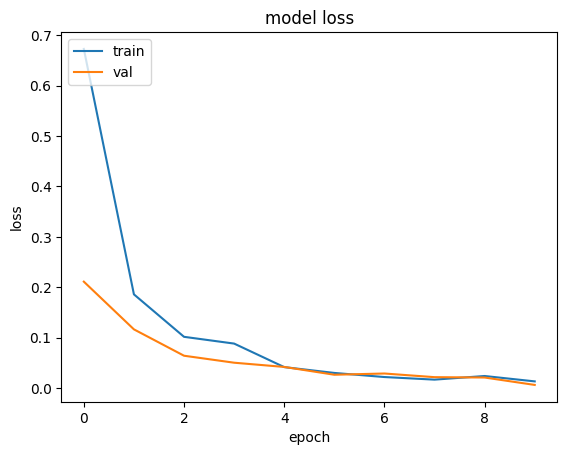

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

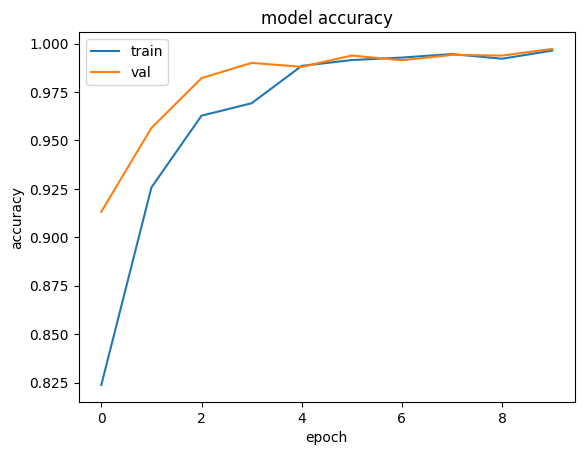

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

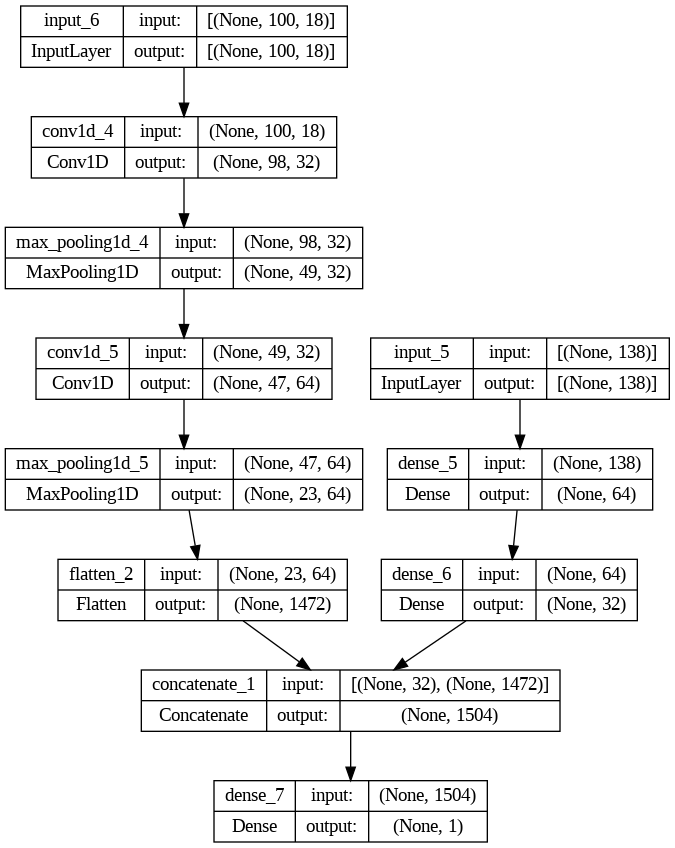

In [29]:
plot_model(model, to_file="/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/hybrid_model_all_data_2.png", show_shapes=True,show_layer_names=True)

### Model (Severity Detection)

In [51]:
set(level)

{0, 1, 2, 3}

In [50]:
level.replace(2, 1, inplace= True) 
level.replace(3, 2, inplace= True)  
level.replace(4, 3, inplace= True)  
level=level.astype('int')

In [52]:
from keras.utils import to_categorical
y_onehot = to_categorical(level, num_classes=4)

In [59]:
# Split the data into training and testing sets
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(features, result, y_onehot, test_size=0.2, random_state=42)

# Define the input layers for the two datasets
input1 = Input(shape=(features.shape[1],))
input2 = Input(shape=(result.shape[1], result.shape[2]))

# Define the dense layers for the first dataset
dense1 = Dense(64, activation='relu')(input1)
dense2 = Dense(32, activation='relu')(dense1)

# Define the convolutional layers for the second dataset
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# Concatenate the outputs of the two datasets
concat = concatenate([dense2, flatten])

# Define the output layer for binary classification
output = Dense(4, activation='softmax')(concat)

# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting during training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with both datasets
history = model.fit([X_train1, X_train2], y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
365/365 [==============================] - 6s 10ms/step - loss: 0.7149 - accuracy: 0.5846 - val_loss: 0.2942 - val_accuracy: 0.7579
Epoch 2/10
365/365 [==============================] - 2s 6ms/step - loss: 0.2221 - accuracy: 0.8449 - val_loss: 0.1434 - val_accuracy: 0.9273
Epoch 3/10
365/365 [==============================] - 2s 6ms/step - loss: 0.1275 - accuracy: 0.9294 - val_loss: 0.1196 - val_accuracy: 0.9328
Epoch 4/10
365/365 [==============================] - 2s 6ms/step - loss: 0.0754 - accuracy: 0.9680 - val_loss: 0.0594 - val_accuracy: 0.9787
Epoch 5/10
365/365 [==============================] - 2s 6ms/step - loss: 0.0433 - accuracy: 0.9835 - val_loss: 0.0425 - val_accuracy: 0.9835
Epoch 6/10
365/365 [==============================] - 3s 8ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0314 - val_accuracy: 0.9866
Epoch 7/10
365/365 [==============================] - 3s 7ms/step - loss: 0.0222 - accuracy: 0.9932 - val_loss: 0.0219 - val_accuracy: 0.9925
Epoch

In [62]:
# Evaluate the model on the test set
score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.014444105327129364
Test accuracy: 0.9972572922706604


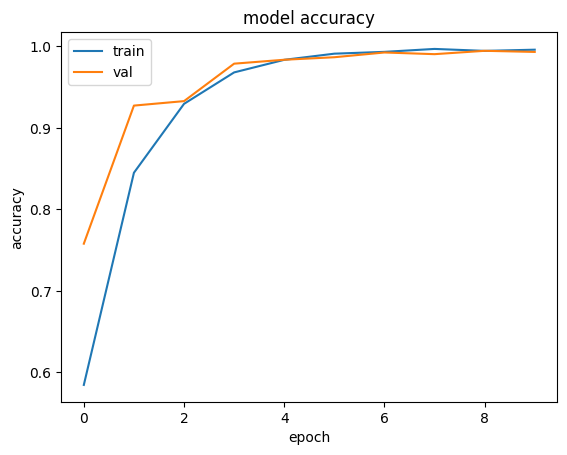

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

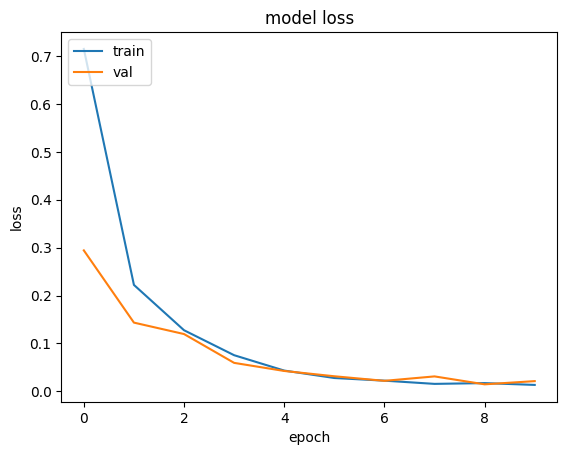

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

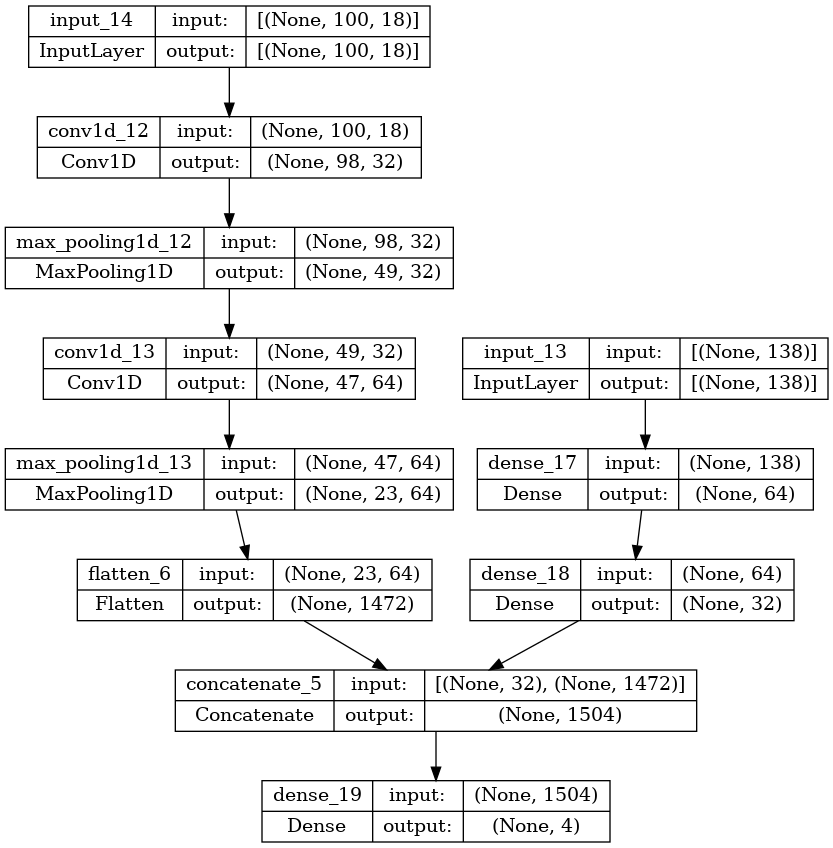

In [63]:
plot_model(model, to_file="/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/hybrid_model_all_data_statics_multi.png", show_shapes=True,show_layer_names=True)